## Basics of TS:

Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them

## Objective:
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

## Imports:


In [3]:
# always start with checking out the files!
!ls ./data/*

./data/item_categories.csv  ./data/sales_train.csv	  ./data/shops.csv
./data/items.csv	    ./data/sample_submission.csv  ./data/test.csv


In [4]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")



In [5]:
# Import all of them 
sales=pd.read_csv("./data/sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("./data/item_categories.csv")
item=pd.read_csv("./data/items.csv")
sub=pd.read_csv("./data/sample_submission.csv")
shops=pd.read_csv("./data/shops.csv")
test=pd.read_csv("./data/test.csv")

In [42]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

In [48]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [7]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [8]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [49]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


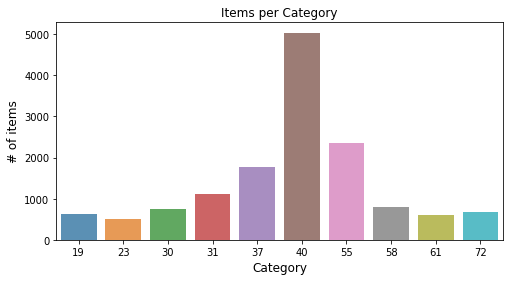

In [9]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.


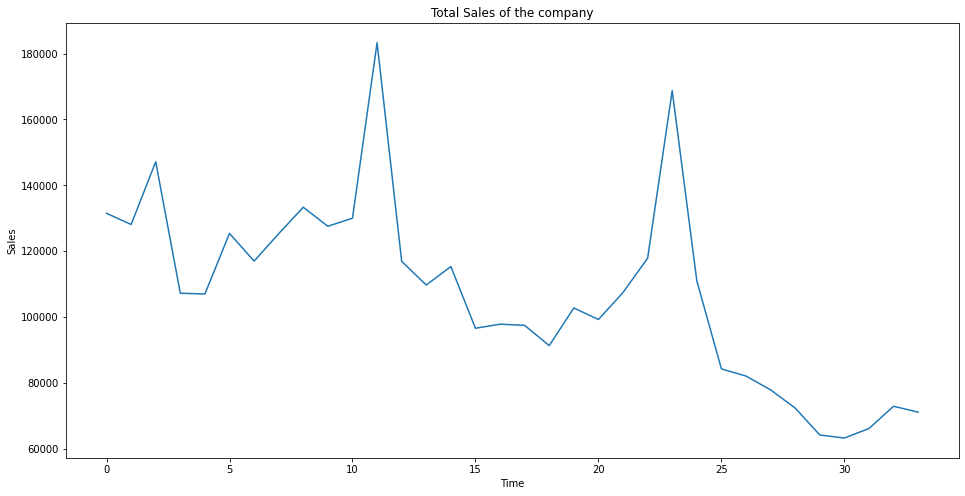

In [10]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

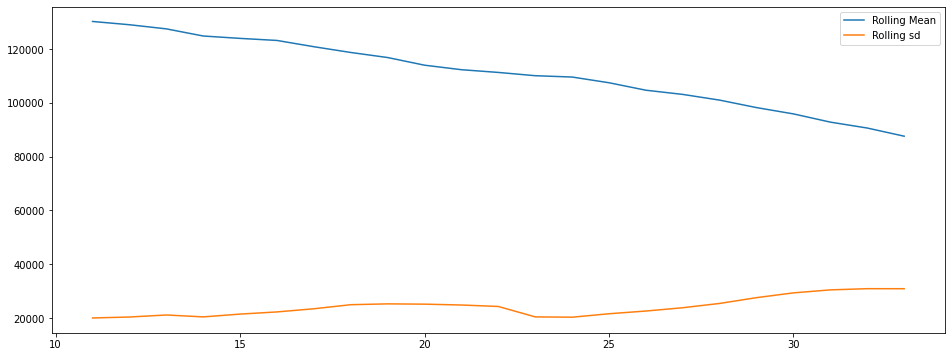

In [11]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:**
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.


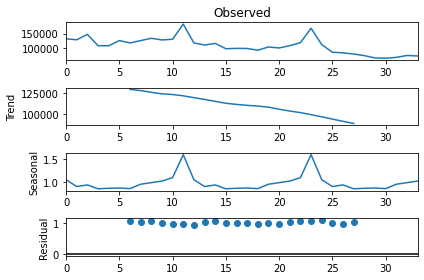

In [12]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

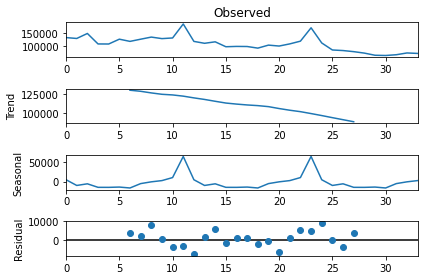

In [13]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [14]:
# R version ported into python  

# alas ! rpy2 does not exist in Kaggle kernals :( 
# from rpy2.robjects import r
# def decompose(series, frequency, s_window, **kwargs):
#     df = pd.DataFrame()
#     df['date'] = series.index
#     s = [x for x in series.values]
#     length = len(series)
#     s = r.ts(s, frequency=frequency)
#     decomposed = [x for x in r.stl(s, s_window, **kwargs).rx2('time.series')]
#     df['observed'] = series.values
#     df['trend'] = decomposed[length:2*length]
#     df['seasonal'] = decomposed[0:length]
#     df['residual'] = decomposed[2*length:3*length]
#     return df

we assume an additive model, then we can write

> yt=St+Tt+Et 

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t
Similarly for Multiplicative model,

> yt=St  x Tt x Et 

## Stationarity:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


There are multiple tests that can be used to check stationarity.
* ADF( Augmented Dicky Fuller Test) 
* KPSS 
* PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)


In [15]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [16]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob



[]

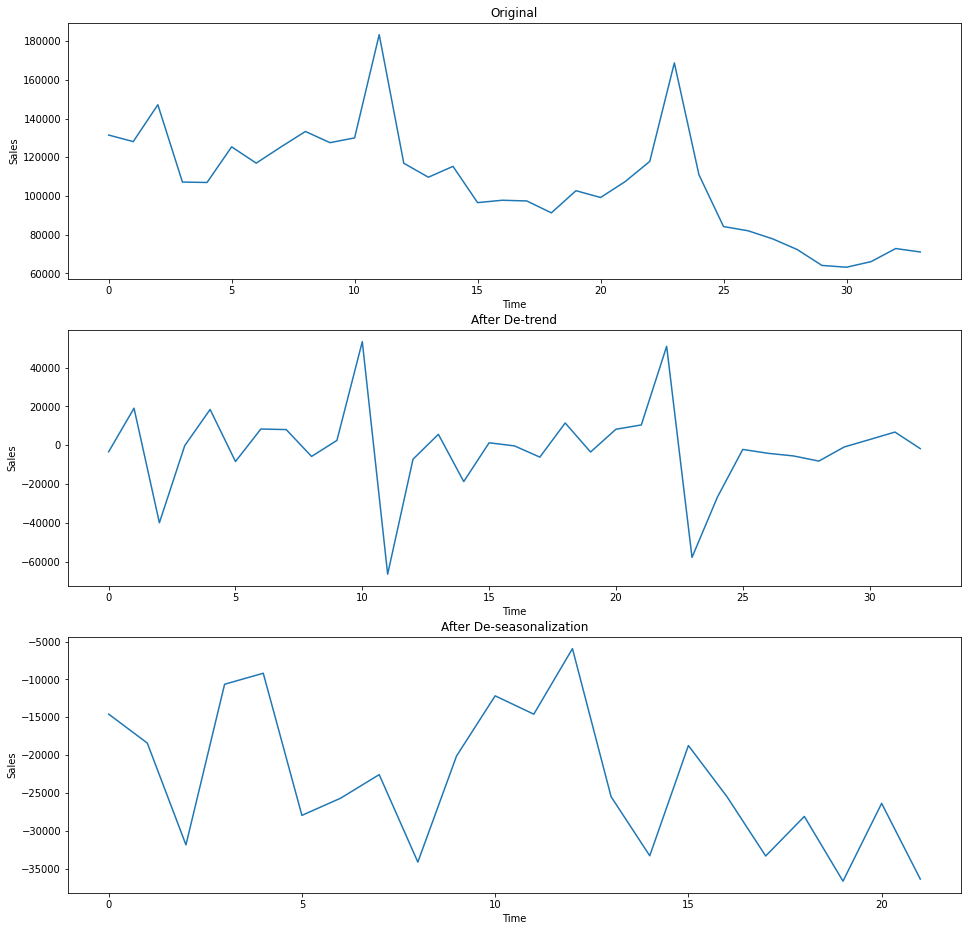

In [17]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [18]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!

# AR, MA and ARMA models:
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values
AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values
ARMA - a mixture of both.

Now, How do we find out, if our time-series in AR process or MA process?

Let's find out!

In [19]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

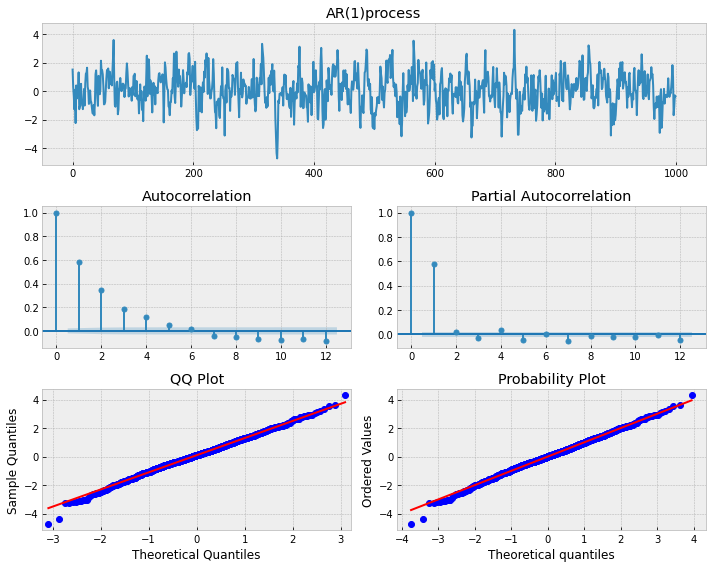

In [20]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

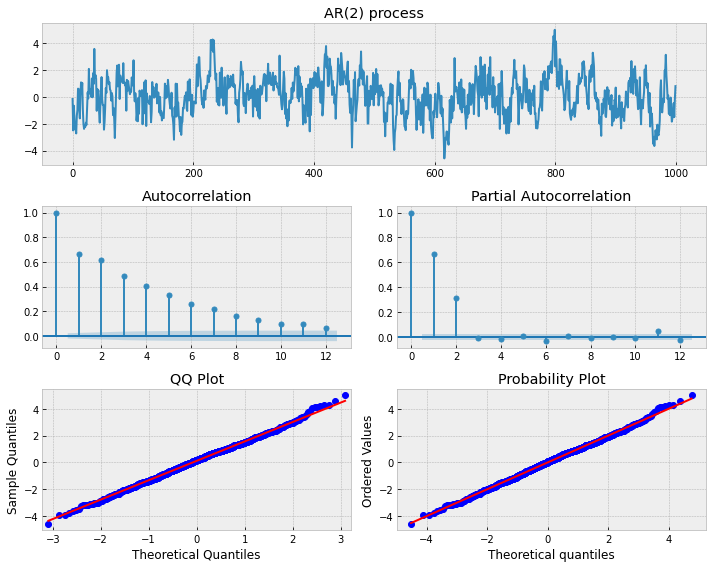

In [21]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

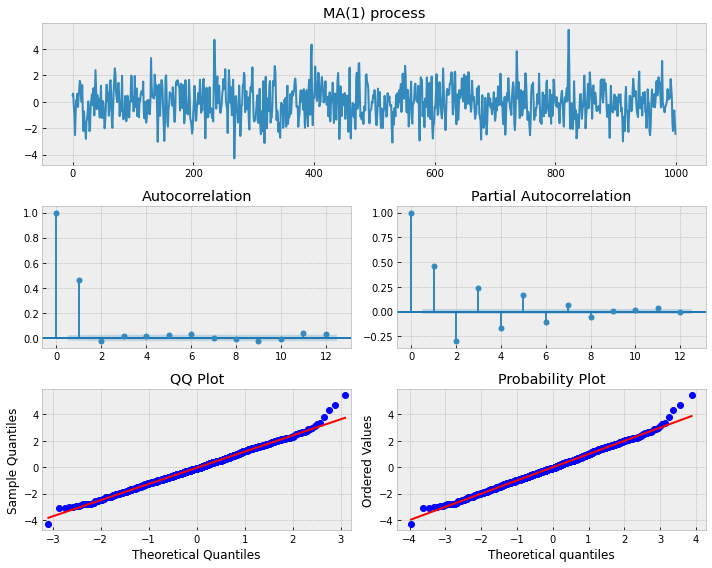

In [22]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

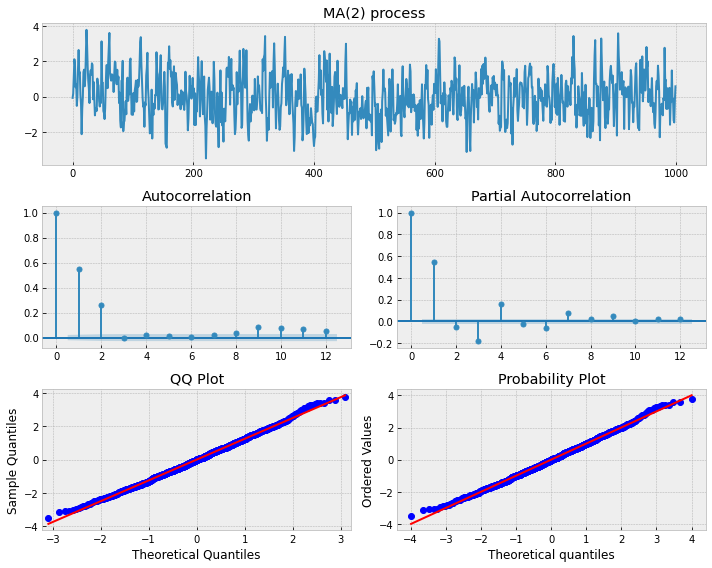

In [23]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

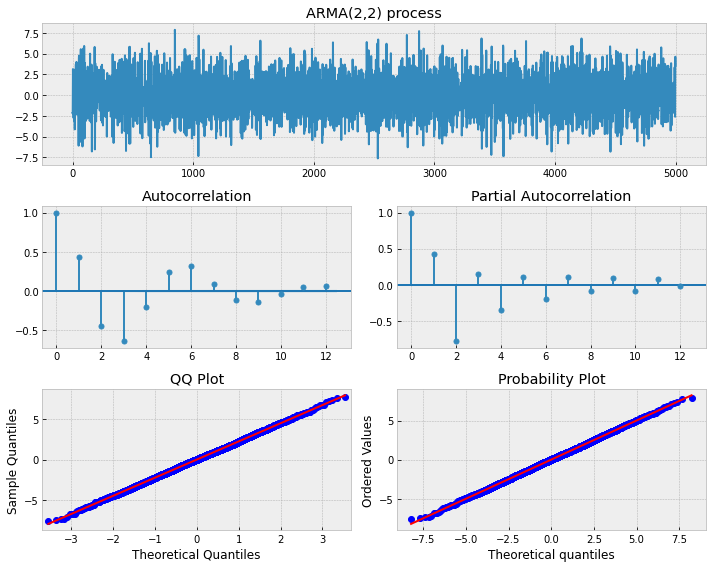

In [24]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## Now things get a little hazy. Its not very clear/straight-forward.

A nifty summary of the above plots:

ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |


## Let's use a systematic approach to finding the order of AR and MA processes.

In [25]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 15326.68109 | order: (2, 2)


## We've correctly identified the order of the simulated process as ARMA(2,2). 

### Lets use it for the sales time-series.


In [26]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 472.99703 | order: (1, 1)


In [27]:
# Simply use best_mdl.predict() to predict the next values

In [28]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet: 

Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating **flatline** :P

![FLATLINE](https://i.stack.imgur.com/fWzyX.jpg)

Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen. 

But the truth is that most of us don't either have the patience or the expertise to make it happen.

Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted.
Eg: This competition. It requires us to predict the next month sales for the **Store - item level combinations** which could be in the thousands.(ie) predict 1000s of parameters!

Another neat functionality is that it follows the typical **sklearn** syntax.

At its core, the Prophet procedure is an additive regression model with four main components:
* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

**Resources for learning more about prophet:**
* https://www.youtube.com/watch?v=95-HMzxsghY
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://research.fb.com/prophet-forecasting-at-scale/
* https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [29]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957124,80157.850100,86253.821780
35,2015-12-01,125513.062783,122507.614644,128527.676682
36,2016-01-01,75625.688398,72334.504208,78761.261917
37,2016-02-01,40109.144293,36826.923877,43146.889296
38,2016-03-01,76664.084484,73570.379710,79724.131667


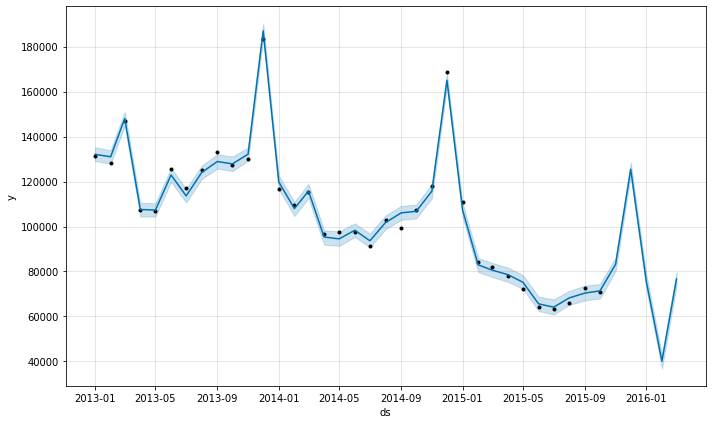

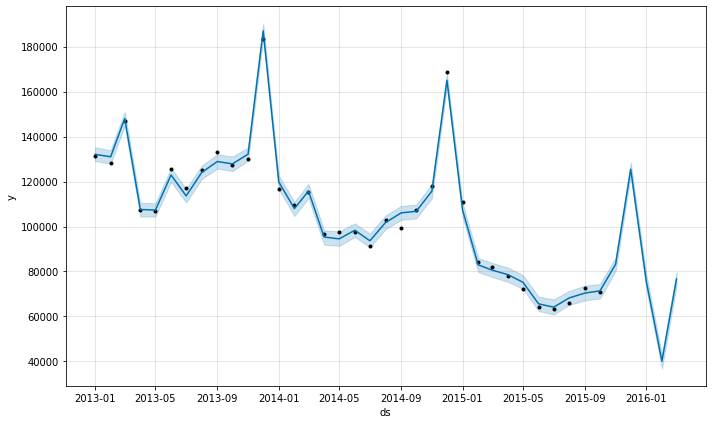

In [31]:
model.plot(forecast)

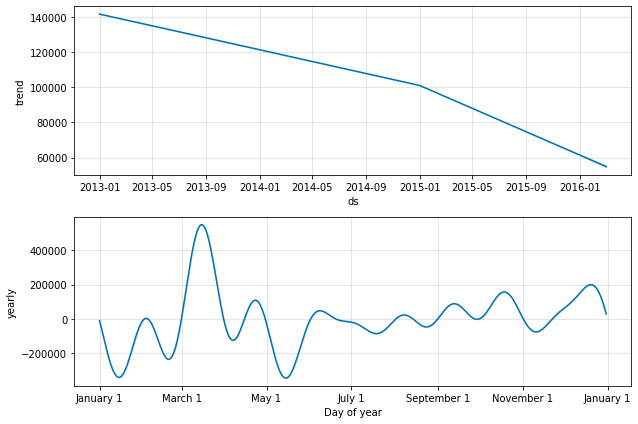

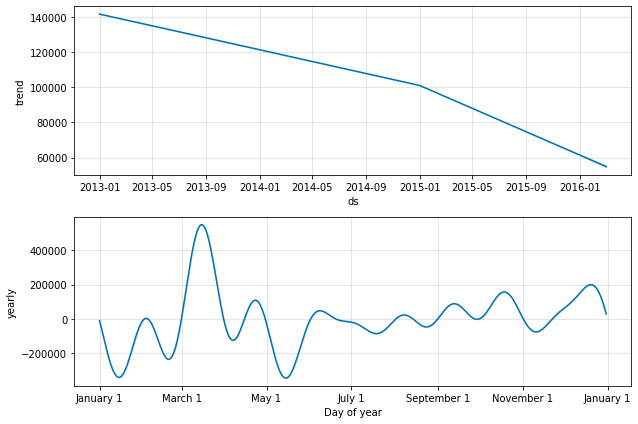

In [32]:
model.plot_components(forecast)

Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

## UCM:

Unobserved Components Model. The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.

Unfortunately, I could not find a good package/code that can perform this model in Python :( 

R version of UCM: https://bicorner.com/2015/12/28/unobserved-component-models-in-r/

# Hierarchical time series:

The [Forecasting: principles and practice](https://www.otexts.org/fpp/9/4) , is the ultimate reference book for forecasting by Rob J Hyndman.

He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.

![](https://www.otexts.org/sites/default/files/resize/fpp/images/hts1-550x274.png)

Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.

### Bottom up approach:
* Predict all the base level series using any method, and then just aggregate it to the top.
* Advantages: Simple , No information is lost due to aggregation.
* Dis-advantages: Lower levels can be noisy

### Top down approach:
* Predict the top level first. (Eg: predict total sales first)
* Then calculate **weights** that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales 
* There are different ways of arriving at the "weights". 
    * **Average Historical Proportions** - Simple average of the item's contribution to sales in the past months
    * **Proportion of historical averages** - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
    * **Forecasted Proportions** - Predict the proportion in the future using changes in the past proportions
* Use these weights to calcuate the base -forecasts and other levels

### Middle out:
* Use both bottom up and top down together.
* Eg: Consider our problem of predicting store-item level forecasts.
    * Take the middle level(Stores) and find forecasts for the stores
    * Use bottoms up approach to find overall sales
    * Dis-integrate store sales using proportions to find the item-level sales using a top-down approach
    
### Optimal combination approach:
* Predict for all the layers independently
* Since, all the layers are independent, they might not be consistent with hierarchy
    * Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store  or as Hyndman puts it “aggregate consistent”
* Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy


### Enough with the theory. Lets start making forecasts! :P
The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a **million** individual time-series(item-store combinations) that we need to predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here: 
* Not all stores sell all items
* What happens when a new product is introduced? 
* What if a product is removed off the shelves?

In [33]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [34]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [35]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

~16s for 10 predictions. We need a million predictions. This would not work out.

# Middle out:
Let's predict for the store level

In [36]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [37]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [38]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [39]:
predictions_unknown=predictions[-1]
predictions_unknown

array([  240.81393199,   116.28589295,  1107.83774069,   888.86026241,
        1465.17303399,  1311.88427115,  2553.96936979,  1874.98195574,
        -103.61300883,   581.58033273,   706.7584699 ,    29.36442879,
        3684.86252505,  -533.01327146,  1125.91098769,  2102.61617935,
        1235.63257119,  1620.531595  ,  1507.99916018,  1901.99325381,
        -681.46089586,  2090.00319908,  1744.75145834,  -742.48402473,
        2329.3646388 ,  6642.37729169,  1533.45752652,  6841.03563707,
        4470.31106098,   145.57284576,   296.75210122,  8209.01219785,
       -1266.81428445,   775.57252869])

## Under construction...........

### Unconventional techniques: converting TS into a regression problem

### Dealing with Hierarchy
### Codes for top down, optimal ,etc



## Foot-notes:

I'm not a stats major, so please do let me know in the comments if you feel that I've left out any important technique or if there was any mistake in the content.

I plan to add another kernel about Time-series here which would be about adapting the open-source solutions from the recent time-series competitions ( Favorita, Recruit,etc. ) to this playground dataset.

Do leave a comment/upvote :) 